<a href="https://colab.research.google.com/github/VIVEK-JADHAV/QuoraQuestionPair/blob/main/QuoraModelAndEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing important libraries
import numpy as np
import pandas as pd
import os
import shutil
import pickle
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Flatten,Embedding,LSTM,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

tf.config.run_functions_eagerly(True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Loading the train data 
train=pd.read_csv('/content/data/train.csv')
train.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Model Building

In [ ]:
#Model Archietecture

#Input Layer
input_layer_q1=Input((ques1_mx_length,),name='input_layer_q1')
input_layer_q2=Input((ques2_mx_length,),name='input_layer_q2')

#Embedding layer
embedding_layer_q1=Embedding(vocab_size,100,input_length=ques1_mx_length,weights=[embedding_matrix],
                             trainable=False,mask_zero=True)(input_layer_q1)
embedding_layer_q2=Embedding(vocab_size,100,input_length=ques2_mx_length,weights=[embedding_matrix],
                             trainable=False,mask_zero=True)(input_layer_q2) 

#Bidirectional LSTM
bi_lstm=tf.keras.layers.Bidirectional(LSTM(64, name='lstm',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=20),
                 recurrent_initializer=tf.keras.initializers.orthogonal(seed=30)))
bi_lstm_q1=bi_lstm(embedding_layer_q1)
bi_lstm_q2=bi_lstm(embedding_layer_q2) 

func=lambda x: K.abs(x[0]-x[1])
distance=Lambda(func)([bi_lstm_q1,bi_lstm_q2])

#Output layer
output=Dense(1,activation='sigmoid')(distance)

model=Model(inputs=[input_layer_q1,input_layer_q2],outputs=[output])

model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_q1 (InputLayer)     [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_layer_q2 (InputLayer)     [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 21, 100)      23063900    input_layer_q1[0][0]             
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 24, 100)      23063900    input_layer_q2[0][0]             
____________________________________________________________________________________________

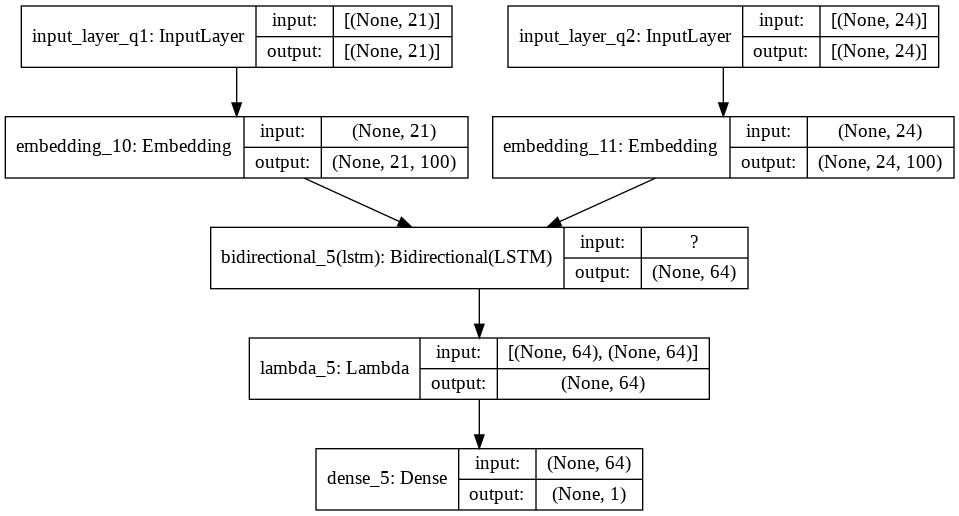

In [ ]:
#Model archietecture with shapes
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [ ]:
#Creating  directory for model and weights 

os.mkdir('/content/Model')
os.mkdir('/content/model_save')

In [ ]:
#Custom Performance metric: AUC value

from sklearn.metrics import roc_auc_score

def auc_value(y_true,y_pred):
  try:
    return tf.py_function(roc_auc_score,(y_true,y_pred),tf.float32)
  except :
    return 0

In [ ]:
#Setting the parameters for TensorBoard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf ./logs/ 

log_dir='/content/Model'
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Save  model at every epoch
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="/content/model_save/weights-{epoch:02d}-{val_auc_value:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc_value', verbose=1, save_best_only=True, mode='auto')

In [ ]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',metrics=[auc_value])

In [ ]:
#Fitting the model and running it for 10 epochs
callback=[tensorboard_callback,checkpoint]
model.fit([ques1_train,ques2_train],Y_train,batch_size=64,epochs=5,callbacks=callback,
           validation_data=([ques1_val,ques2_val],Y_val))

Epoch 1/5
4296/4296 [==============================] - 326s 76ms/step - loss: 0.5202 - auc_value: 0.8017 - val_loss: 0.4384 - val_auc_value: 0.8641

Epoch 00001: val_auc_value improved from inf to 0.86405, saving model to /content/model_save/weights-01-0.8641.hdf5
Epoch 2/5
4296/4296 [==============================] - 327s 76ms/step - loss: 0.4169 - auc_value: 0.8781 - val_loss: 0.4225 - val_auc_value: 0.8754

Epoch 00002: val_auc_value did not improve from 0.86405
Epoch 3/5
4296/4296 [==============================] - 328s 76ms/step - loss: 0.3785 - auc_value: 0.9009 - val_loss: 0.4133 - val_auc_value: 0.8811

Epoch 00003: val_auc_value did not improve from 0.86405
Epoch 4/5
4296/4296 [==============================] - 316s 74ms/step - loss: 0.3521 - auc_value: 0.9152 - val_loss: 0.4122 - val_auc_value: 0.8830

Epoch 00004: val_auc_value did not improve from 0.86405
Epoch 5/5
4296/4296 [==============================] - 319s 74ms/step - loss: 0.3299 - auc_value: 0.9261 - val_loss: 0.4

In [ ]:
%tensorboard --logdir '/content/Model'

The train loss and validation loss initially reduced but after epoch3, the validation loss flattened and train loss further reduced indicating overfitting.
Hence, considering the model weights at the end of epoch 3.

### Evaluation


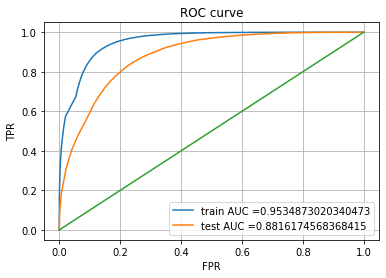

In [ ]:
#Plot AUC curve
from sklearn.metrics import roc_curve,auc

y_train_pred = model.predict([ques1_train,ques2_train])
y_val_pred = model.predict([ques1_val,ques2_val])

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
val_fpr, val_tpr, val_thresholds = roc_curve(Y_val, y_val_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(val_fpr, val_tpr, label="test AUC ="+str(auc(val_fpr, val_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [ ]:
#Finding the best threshold
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]    
    print("The maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#Converting probabilities to predicted values
def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
#Printing the confusion matrix
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
print(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))

print("Val confusion matrix")
print(confusion_matrix(Y_val, predict_with_best_t(y_val_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.7874456042677307 for threshold 0.383
Train confusion matrix
[[149445  23971]
 [  8754  92744]]
Val confusion matrix
[[30488  7766]
 [ 4418 17972]]


The best threshold value is 0.383. If the prbability is greater than 0.383, the questions are similar

In [ ]:
#Printing Precision,Recall and F1-score

from sklearn.metrics import classification_report

print('Train Data')
print(classification_report(Y_train, predict_with_best_t(y_train_pred, best_t)))

print('Validation Data')
print(classification_report(Y_val, predict_with_best_t(y_val_pred, best_t)))

Train Data
              precision    recall  f1-score   support

           0       0.94      0.86      0.90    173416
           1       0.79      0.91      0.85    101498

    accuracy                           0.88    274914
   macro avg       0.87      0.89      0.88    274914
weighted avg       0.89      0.88      0.88    274914

Validation Data
              precision    recall  f1-score   support

           0       0.87      0.80      0.83     38254
           1       0.70      0.80      0.75     22390

    accuracy                           0.80     60644
   macro avg       0.79      0.80      0.79     60644
weighted avg       0.81      0.80      0.80     60644



In [ ]:
#Saving the model
model.save('/content/model')
!zip -r '/content/model.zip' '/content/model'

In [ ]:
#Saving the tokenizer as pickle file
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

### Test data


In [ ]:
#Loading the saved model
model=tf.keras.models.load_model('/content/data/content/model',custom_objects={'auc_value':auc_value}, compile=False)

In [ ]:
#Performance evaluation on hold out test data
print('The shape of X_test data',X_test.shape)
print('The shape of Y_test data',Y_test.shape)

ques1_mx_length=21
ques2_mx_length=24

ques1_test = tokenizer.texts_to_sequences(X_test['question1'])
ques2_test = tokenizer.texts_to_sequences(X_test['question2'])

ques1_test = tf.keras.preprocessing.sequence.pad_sequences(ques1_test,padding='post',maxlen=ques1_mx_length)
ques2_test = tf.keras.preprocessing.sequence.pad_sequences(ques2_test,padding='post',maxlen=ques2_mx_length)

y_test_pred = model.predict([ques1_test,ques2_test])

print("Test confusion matrix")
print(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))

print('Test Data Classification report')
print(classification_report(Y_test, predict_with_best_t(y_test_pred, best_t)))

The shape of X_test data (68729, 2)
The shape of Y_test data (68729,)
Test confusion matrix
[[34510  8844]
 [ 4986 20389]]
Test Data Classification report
              precision    recall  f1-score   support

           0       0.87      0.80      0.83     43354
           1       0.70      0.80      0.75     25375

    accuracy                           0.80     68729
   macro avg       0.79      0.80      0.79     68729
weighted avg       0.81      0.80      0.80     68729



The model has overall accuracy of 0.8 with high precision and recall